# P0: Intro

Name: Niki Sepasian \
Student Number: 400105003

<center><b>Machine Learning Project</b></center>
<br><center><b>Sharif University of Technology - Fall 2023</b></center>

<div style="text-align:justify">Hopefully, the course has been insightful for you till now. This notebook serves as a template for the project which involves training a sentiment analyzer neural network using the comments of a Persian website and fine-tuning it using the comments of another.<br><br>
The first website is Snappfood which is used by the people in Iran to order different kinds of food. The latter is Digikala, an online store for Iranians where people buy many things including smartphones, groceries, cars, and whatever you consider legal. Both websites provide users with ways to express their opinions about the products.<br><br>
A domain shift may be revealed to some degree when switching from Snappfood comments to the ones extracted from Digikala. This will be one of the challenges you will be faced with. So, beware of it!</div>

# P1: Exploring the Datasets (25 points)

Both of the datasets are added to the notebook. In this part, we want to explore their contents. 

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

Load both of the datasets 

In [2]:
df_digi= pd.read_csv("/kaggle/input/digikala-comments-persian-sentiment-analysis/data.csv")
df_snapp= pd.read_csv("/kaggle/input/snappfood-persian-sentiment-analysis/Snappfood - Sentiment Analysis.csv", encoding='utf-8', sep='\t+')

/tmp/ipykernel_42/1437460397.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_snapp= pd.read_csv("/kaggle/input/snappfood-persian-sentiment-analysis/Snappfood - Sentiment Analysis.csv", encoding='utf-8', sep='\t+')


In [3]:
df_digi.dropna()
df_digi.head(5)

,Text,Score,Suggestion
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1
1,خرید این محصول رو توصیه میکنم,84,1
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1


In [4]:
df_snapp.dropna()
df_snapp.head(5)

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0


Count the number of comments each dataset contains **(P1-1: 5 points)**

In [5]:
print("digikala number of comments:", df_digi.shape[0])
print("snappfood number of comments:", df_snapp.shape[0])

digikala number of comments: 3261
snappfood number of comments: 70000


Represent the distribution of comments in the Snappfood dataset in terms of being negative or positive **(P1-2: 5 points)**

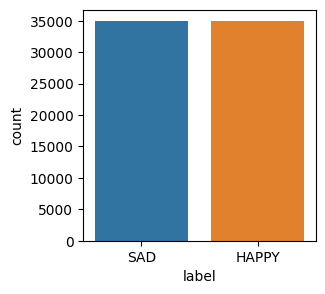

In [6]:
plt.figure(figsize=(3, 3))
sns.countplot(x= 'label', data= df_snapp)
plt.show()

Plot the logarithm of the frequency of words as a function of the logarithm of their rank to demonstrate the Zipf's law. <br>
Note: Don't panic! The Zipf's law can be found here: https://nlp.stanford.edu/IR-book/html/htmledition/zipfs-law-modeling-the-distribution-of-terms-1.html and can be easily understood. **(P1-3: 5 points)**

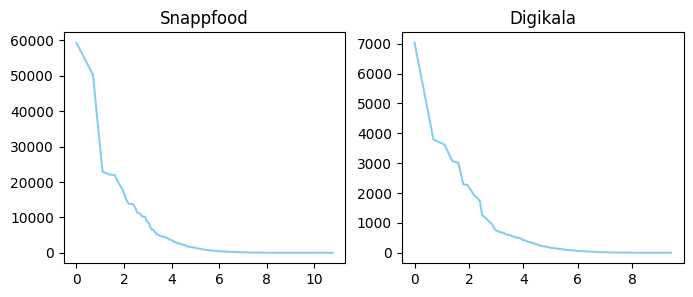

In [7]:
from nltk import FreqDist
fig,axs= plt.subplots(1, 2, figsize=(8, 3))

words= []
for c in df_snapp['comment']:
    words.extend(c.split())
freq_dist= FreqDist(words)
x= np.log(list(range(1, len(freq_dist)+1)))
y= sorted(list(freq_dist.values()), reverse=True)

axs[0].plot(x, y,  linestyle='-', color='skyblue')
axs[0].set_title("Snappfood")
#########################################################
words= []
for c in df_digi['Text']:
    words.extend(c.split())
freq_dist= FreqDist(words)
x= np.log(list(range(1, len(freq_dist)+1)))
y= sorted(list(freq_dist.values()), reverse=True)

axs[1].plot(x, y,  linestyle='-', color='skyblue')
axs[1].set_title("Digikala")


plt.show()

Add a new column to the Digikala dataset indicating whether the comment was positive, negative, or neutral. This will be needed later for classification. <br>
Note: This can be done in many ways. You should the appropriate method. **(P1-4: 5 points)**

In [8]:
for i in range(df_digi.shape[0]):
    scr= df_digi.at[i, 'Score']
    sug= df_digi.at[i, 'Suggestion']
    res= scr-sug*10
    if res>=70:
        df_digi.loc[i, 'Sentiment']= 'positive'
    elif res>=50:
        df_digi.loc[i, 'Sentiment']= 'neutral'
    else:
        df_digi.loc[i, 'Sentiment']= 'negative'
df_digi.head(5)

,Text,Score,Suggestion,Sentiment
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1,positive
1,خرید این محصول رو توصیه میکنم,84,1,positive
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1,neutral
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1,positive
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1,positive


Split each dataset into training, testing, and validation sets. **(P1-5: 5 points)**

In [9]:
from sklearn.model_selection import train_test_split
encoded= pd.get_dummies(df_digi, columns=['Sentiment'], dtype=int)
y_digi= np.array([encoded['Sentiment_positive'].to_list(), encoded['Sentiment_neutral'].to_list(), encoded['Sentiment_negative'].to_list()]).T

x_train_digi, x_test_digi, y_train_digi, y_test_digi= train_test_split(df_digi['Text'], y_digi, train_size=0.8, shuffle=True)
x_val_digi, x_test_digi, y_val_digi, y_test_digi= train_test_split(x_test_digi, y_test_digi, train_size=0.5, shuffle=True)

x_train_snapp, x_test_snapp, y_train_snapp, y_test_snapp= train_test_split(df_snapp['comment'], df_snapp['label_id'], train_size=0.8, shuffle=True, random_state= 42)
x_val_snapp, x_test_snapp, y_val_snapp, y_test_snapp= train_test_split(x_test_snapp, y_test_snapp, train_size=0.5, shuffle=True, random_state= 42)

# P2: Preprocessing and Feature Extraction (20 points)

The goal of this part is to make the Snappfood dataset ready for the neural network to be trained with.<br>
Note: You can use many libraries including `NLTK`, `Spacy`, `Hazm`, `Parsivar`, `Stanza` etc.

In [10]:
!pip install hazm
!pip install parsivar

  Obtaining dependency information for hazm from https://files.pythonhosted.org/packages/91/8c/cc3d01c27681eb8223781ea162a23f9926647ce864eb601a19aee4bce0af/hazm-0.10.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 32.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.1 MB/s eta 0:00:00
  Obtaining dependency information for python-crfsuite<0.10.0,>=0.9.9 from https://files.pythonhosted.org/packages/38/1d/c475ba7d11e9735f00eb08e2f5315aa2e21c24cc85a0474c3fd425edef58/python_crfsuite-0.9.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.0 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into a

Remove the unnecessary characters of the dataset. <br>
**(P2-1: 5 points)**

In [11]:
import re

# x_train_digi= x_train_digi.apply(lambda x: re.sub(r'[^\s\u0600-\u06FF]+', "", x))
# x_test_digi= x_test_digi.apply(lambda x: re.sub(r'[^\s\u0600-\u06FF]+', "", x))
# x_val_digi= x_val_digi.apply(lambda x: re.sub(r'[^\s\u0600-\u06FF]+', "", x))

x_train_snapp= x_train_snapp.apply(lambda x: re.sub(r'[^\s|\u0600-\u06FF]+', "", x))
x_test_snapp= x_test_snapp.apply(lambda x: re.sub(r'[^\s|\u0600-\u06FF]+', "", x))
x_val_snapp= x_val_snapp.apply(lambda x: re.sub(r'[^\s|\u0600-\u06FF]+', "", x))

Normalize the dataset. <br>
Note: Check the result. For instance, if you do this correctly, you'll have a dataset containing just 1 type of space. **(P2-2: 5 points)**

In [12]:
from hazm import Normalizer

normalizer= Normalizer()

# x_train_digi.apply(lambda x: normalizer.normalize(x))
# x_test_digi.apply(lambda x: normalizer.normalize(x))
# x_val_digi.apply(lambda x: normalizer.normalize(x))

x_train_snapp= x_train_snapp.apply(lambda x: normalizer.normalize(x))
x_test_snapp= x_test_snapp.apply(lambda x: normalizer.normalize(x))
x_val_snapp= x_val_snapp.apply(lambda x: normalizer.normalize(x))

If you want to include other preprocessing steps, put all of your code here.

In [13]:
from hazm.utils import stopwords_list
from parsivar import Tokenizer
tokenizer= Tokenizer()
def tokenize_and_remove_stopword(x):
    tokens= tokenizer.tokenize_words(x)
    return ([tok for tok in tokens if tok not in stopwords_list()])

# x_train_digi.apply(tokenize_and_remove_stopword)
# x_test_digi.apply(tokenize_and_remove_stopword)
# x_val_digi.apply(tokenize_and_remove_stopword)

x_train_snapp= x_train_snapp.apply(tokenize_and_remove_stopword)
x_test_snapp= x_test_snapp.apply(tokenize_and_remove_stopword)
x_val_snapp= x_val_snapp.apply(tokenize_and_remove_stopword)

In [14]:
x_train_snapp= x_train_snapp.apply(lambda x: ' '.join(x))
x_test_snapp= x_test_snapp.apply(lambda x: ' '.join(x))
x_val_snapp= x_val_snapp.apply(lambda x: ' '.join(x))

Extract features from the Snappfood dataset
<br> Note: You should use both of the following methods, and compare the results at the end.
- Method 1 (Classic): Use `CountVectorizer` or `TF-IDF`.
- Method 2 (Modern): Use `Word2Vec`, `FastText`, `GloVe`, `Doc2Vec` or train your own `Embedding` Layer. 

If you choose to train your own `Embedding`s, you'll just need to specify an ID for each word remaining in your dataset. **(P2-3: 10 points)**

In [15]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer


######################## tfidf

tfidvec= TfidfVectorizer(max_features= 100)
tf_x_train_snapp= tfidvec.fit_transform(x_train_snapp).toarray()
tf_x_test_snapp= tfidvec.transform(x_test_snapp).toarray()
tf_x_val_snapp= tfidvec.transform(x_val_snapp).toarray()

######################## word2vec


def get_vec(m, words):
    vec= [m.wv[word] for word in words if word in m.wv] 
    if vec:
        return np.mean(vec, axis= 0)
    return np.zeros(w2v.vector_size)


w2v= Word2Vec([x.split() for x in x_train_snapp], vector_size= 100, window=5, min_count=1, workers=4)
w2v_x_train_snapp = np.array([get_vec(w2v, sent.split()) for sent in x_train_snapp])


# w2v= Word2Vec([x.split() for x in x_test_snapp], vector_size= 100, window=5, min_count=1, workers=4)
w2v_x_test_snapp = np.array([get_vec(w2v, sent.split()) for sent in x_test_snapp])

# w2v= Word2Vec([x.split() for x in x_val_snapp], vector_size= 100, window=5, min_count=1, workers=4)
w2v_x_val_snapp = np.array([get_vec(w2v, sent.split()) for sent in x_val_snapp])


# P3: Training and Initial Evaluation (20 points)

Define an architecture for your neural network. **(P3-1: 5 points)**

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D, GlobalMaxPooling1D, BatchNormalization

def make_model():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(100, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
#     model= Sequential()
#     model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(100, 1)))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.5))
#     model.add(LSTM(64))
#     model.add(Dropout(0.5))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

w2v_model= make_model()
tf_model= make_model()

In [26]:
w2v_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 98, 64)            256       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 49, 64)            0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 49, 64)            0         
                                                                 
 bidirectional (Bidirection  (None, 49, 128)           66048     
 al)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 49, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)              

In [27]:
tf_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 98, 64)            256       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 49, 64)            0         
 g1D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 49, 64)            0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 49, 128)           66048     
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 49, 128)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)              

Train the network on the Snappfood dataset, while monitoring its performance on the validation set. **(P3-2: 5 points)**

In [25]:
w2v_model.fit(w2v_x_train_snapp, y_train_snapp, epochs=5, batch_size=64,validation_data=(w2v_x_val_snapp, y_val_snapp))

Epoch 1/5
875/875 [==============================] - 94s 99ms/step - loss: 0.4978 - accuracy: 0.7564 - val_loss: 0.4562 - val_accuracy: 0.7864
Epoch 2/5
875/875 [==============================] - 86s 98ms/step - loss: 0.4627 - accuracy: 0.7831 - val_loss: 0.4538 - val_accuracy: 0.7856
Epoch 3/5
875/875 [==============================] - 85s 97ms/step - loss: 0.4557 - accuracy: 0.7870 - val_loss: 0.4497 - val_accuracy: 0.7916
Epoch 4/5
875/875 [==============================] - 85s 97ms/step - loss: 0.4512 - accuracy: 0.7892 - val_loss: 0.4435 - val_accuracy: 0.7883
Epoch 5/5
875/875 [==============================] - 84s 96ms/step - loss: 0.4466 - accuracy: 0.7920 - val_loss: 0.4407 - val_accuracy: 0.7940


In [29]:
tf_model.fit(tf_x_train_snapp, y_train_snapp, epochs=5, batch_size=64,validation_data=(tf_x_val_snapp, y_val_snapp))

Epoch 1/5
875/875 [==============================] - 106s 114ms/step - loss: 0.6467 - accuracy: 0.6237 - val_loss: 0.6385 - val_accuracy: 0.6374
Epoch 2/5
875/875 [==============================] - 97s 111ms/step - loss: 0.6171 - accuracy: 0.6544 - val_loss: 0.5913 - val_accuracy: 0.6796
Epoch 3/5
875/875 [==============================] - 97s 111ms/step - loss: 0.5915 - accuracy: 0.6759 - val_loss: 0.5709 - val_accuracy: 0.6971
Epoch 4/5
875/875 [==============================] - 96s 110ms/step - loss: 0.5685 - accuracy: 0.6961 - val_loss: 0.5510 - val_accuracy: 0.7009
Epoch 5/5
875/875 [==============================] - 97s 111ms/step - loss: 0.5558 - accuracy: 0.7028 - val_loss: 0.5470 - val_accuracy: 0.7149


Evaluate the performance of your network on the Snappfood testing set. **(P3-3: 5 points)**

In [30]:
from sklearn.metrics import accuracy_score, classification_report

w2v_pred= np.round(w2v_model.predict(w2v_x_test_snapp))
print("w2v:")
print("accuracy: ", accuracy_score(y_test_snapp, w2v_pred))
print(classification_report(y_test_snapp, w2v_pred, zero_division=0))

219/219 [==============================] - 6s 21ms/step
w2v:
accuracy:  0.7907142857142857
              precision    recall  f1-score   support

           0       0.84      0.72      0.77      3469
           1       0.76      0.86      0.81      3531

    accuracy                           0.79      7000
   macro avg       0.80      0.79      0.79      7000
weighted avg       0.80      0.79      0.79      7000



In [31]:
tf_pred= np.round(tf_model.predict(tf_x_test_snapp))
print("tf:")
print("accuracy: ", accuracy_score(y_test_snapp, tf_pred))
print(classification_report(y_test_snapp, tf_pred, zero_division=0))

219/219 [==============================] - 6s 21ms/step
tf:
accuracy:  0.7122857142857143
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      3469
           1       0.70      0.74      0.72      3531

    accuracy                           0.71      7000
   macro avg       0.71      0.71      0.71      7000
weighted avg       0.71      0.71      0.71      7000



Save the weights of the neural network and its architecture seperately in the notebook's output folder (`/kaggle/working/`). **(P3-4: 5 points)**

In [32]:
import tensorflow as tf

############# w2v
with open('/kaggle/working/w2v_arch.json', 'w') as jsonf:
    jsonf.write(w2v_model.to_json())
w2v_model.save_weights( '/kaggle/working/w2v_w.h5')

############# tf
with open('/kaggle/working/tf_arch.json', 'w') as jsonf:
    jsonf.write(tf_model.to_json())
tf_model.save_weights( '/kaggle/working/tf_w.h5')

# P4: Fine-tuning and Evaluation (35 points)

In this part, we will fine-tune the previously trained network on the comments extracted from Digikala.

Load the neural network along with its weights **(P4-1: 5 points)**

In [33]:
from tensorflow.keras.models import model_from_json

############# w2v
with open('/kaggle/working/w2v_arch.json', 'r') as jsonf:
    load= jsonf.read()
loaded_w2v_model= model_from_json(load)
loaded_w2v_model.load_weights('/kaggle/working/w2v_w.h5')

############# tf
with open('/kaggle/working/tf_arch.json', 'r') as jsonf:
    load= jsonf.read()
loaded_tf_model= model_from_json(load)
loaded_tf_model.load_weights('/kaggle/working/tf_w.h5')

Change the architecture of the network (the last layer) to make it appropriate for classifying the sentiment of a comment in one of the previously mentioned three classes: positive, negative, or neutral. **(P4-2: 5 points)**

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

############# w2v
loaded_w2v_model.layers.pop()
input= loaded_w2v_model.input
output= Dense(3, activation='softmax')(loaded_w2v_model.layers[-1].output)
new_w2v= Model(inputs= input, outputs= output)
new_w2v.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

############# tf
loaded_tf_model.layers.pop()
input= loaded_tf_model.input
output= Dense(3, activation='softmax')(loaded_tf_model.layers[-1].output)
new_tf= Model(inputs= input, outputs= output)
new_tf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Extract features from the Digikala dataset.<br>
Note: Pay attention to the fact that your features are the same as the ones you extracted from the Snappfood dataset. You just need to use the same method for the new dataset. For instance, if you consider the `CountVectorizer` as your feature extractor, the set of the words for which you'll count the frequency will not change! **(P4-3: 15 points)**

In [38]:
######### preprocess
x_train_digi= x_train_digi.apply(lambda x: re.sub(r'[^\s\u0600-\u06FF]+', "", x))
x_test_digi= x_test_digi.apply(lambda x: re.sub(r'[^\s\u0600-\u06FF]+', "", x))
x_val_digi= x_val_digi.apply(lambda x: re.sub(r'[^\s\u0600-\u06FF]+', "", x))
x_train_digi= x_train_digi.apply(lambda x: re.sub(r'[^\s\u0600-\u06FF]+', "", x))
x_test_digi= x_test_digi.apply(lambda x: re.sub(r'[^\s\u0600-\u06FF]+', "", x))
x_val_digi= x_val_digi.apply(lambda x: re.sub(r'[^\s\u0600-\u06FF]+', "", x))
x_train_digi.apply(tokenize_and_remove_stopword)
x_test_digi.apply(tokenize_and_remove_stopword)
x_val_digi.apply(tokenize_and_remove_stopword)


########## extract feature

########## tf
tfidvec= TfidfVectorizer(max_features= 100)
tf_x_train_digi= tfidvec.fit_transform(x_train_digi).toarray()
tf_x_test_digi= tfidvec.transform(x_test_digi).toarray()
tf_x_val_digi= tfidvec.transform(x_val_digi).toarray()

######################## word2vec
w2v= Word2Vec([x.split() for x in x_train_digi], vector_size= 100, window=5, min_count=1, workers=4)
w2v_x_train_digi = np.array([get_vec(w2v, sent.split()) for sent in x_train_digi])


# w2v= Word2Vec([x.split() for x in x_test_digi], vector_size= 100, window=5, min_count=1, workers=4)
w2v_x_test_digi = np.array([get_vec(w2v, sent.split()) for sent in x_test_digi])

# w2v= Word2Vec([x.split() for x in x_val_digi], vector_size= 100, window=5, min_count=1, workers=4)
w2v_x_val_digi = np.array([get_vec(w2v, sent.split()) for sent in x_val_digi])


Fine-tune the network on the training set associated with the Digikala dataset, while monitoring its performance on the corresponding validation set.<br>
Note: The process of fine-tuning should follow one of these methods:
- Method 1: Fix the weights for all layers expect the last one.
- Method 2: Use a really small learning rate for all layers except the last one.

**(P4-4: 5 points)**

In [39]:
from tensorflow.keras.optimizers import Adam

########## set alpha
alpha= 1e-3 

########### w2v
for layer in new_w2v.layers[:-1]:
    layer.trainable= True
    layer.optimizer=Adam(alpha)

######### tf
for layer in new_tf.layers[:-1]:
    layer.trainable= True
    layer.optimizer=Adam(alpha)

In [40]:
new_w2v.fit(w2v_x_train_digi, y_train_digi, epochs=5, batch_size=16, validation_data=(w2v_x_val_digi, y_val_digi))

Epoch 1/5
163/163 [==============================] - 8s 51ms/step - loss: 1.0365 - accuracy: 0.4908 - val_loss: 1.0188 - val_accuracy: 0.4939
Epoch 2/5
163/163 [==============================] - 8s 51ms/step - loss: 1.0374 - accuracy: 0.4908 - val_loss: 1.0132 - val_accuracy: 0.4939
Epoch 3/5
163/163 [==============================] - 8s 48ms/step - loss: 1.0375 - accuracy: 0.4908 - val_loss: 1.0067 - val_accuracy: 0.4939
Epoch 4/5
163/163 [==============================] - 8s 48ms/step - loss: 1.0405 - accuracy: 0.4908 - val_loss: 1.0160 - val_accuracy: 0.4939
Epoch 5/5
163/163 [==============================] - 8s 48ms/step - loss: 1.0375 - accuracy: 0.4908 - val_loss: 1.0123 - val_accuracy: 0.4939


In [41]:
new_tf.fit(tf_x_train_digi, y_train_digi, epochs=5, batch_size=16, validation_data=(tf_x_val_digi, y_val_digi))

Epoch 1/5
163/163 [==============================] - 17s 58ms/step - loss: 1.0846 - accuracy: 0.4494 - val_loss: 1.0647 - val_accuracy: 0.5153
Epoch 2/5
163/163 [==============================] - 8s 48ms/step - loss: 1.0607 - accuracy: 0.5000 - val_loss: 1.0563 - val_accuracy: 0.5092
Epoch 3/5
163/163 [==============================] - 8s 51ms/step - loss: 1.0494 - accuracy: 0.4977 - val_loss: 1.0468 - val_accuracy: 0.4939
Epoch 4/5
163/163 [==============================] - 8s 48ms/step - loss: 1.0459 - accuracy: 0.4908 - val_loss: 1.0374 - val_accuracy: 0.4939
Epoch 5/5
163/163 [==============================] - 8s 48ms/step - loss: 1.0401 - accuracy: 0.4908 - val_loss: 1.0361 - val_accuracy: 0.4939


Evaluate the performance of the neural network on the testing set you have extracted from the Digikala dataset. **(P4-5: 5 points)**

In [42]:
w2v_pred= new_w2v.predict(w2v_x_test_digi).argmax(axis=1)
y= y_test_digi.argmax(axis=1)
print("w2v:")
print("accuracy: ", accuracy_score(y, w2v_pred))
print(classification_report(y, w2v_pred, zero_division=0))

11/11 [==============================] - 2s 21ms/step
w2v:
accuracy:  0.5198776758409785
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       170
           1       0.00      0.00      0.00        77
           2       0.00      0.00      0.00        80

    accuracy                           0.52       327
   macro avg       0.17      0.33      0.23       327
weighted avg       0.27      0.52      0.36       327



In [43]:
tf_pred= new_tf.predict(tf_x_test_digi).argmax(axis=1)
y= y_test_digi.argmax(axis=1)
print("tf:")
print("accuracy: ", accuracy_score(y, tf_pred))
print(classification_report(y, tf_pred, zero_division=0))

11/11 [==============================] - 2s 21ms/step
tf:
accuracy:  0.5198776758409785
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       170
           1       0.00      0.00      0.00        77
           2       0.00      0.00      0.00        80

    accuracy                           0.52       327
   macro avg       0.17      0.33      0.23       327
weighted avg       0.27      0.52      0.36       327

